In [1]:
# NOTE: reduced implementation might require slightly different parameters for same results

## Notebook Config

In [1]:
# Imports
import gc
import os
import sys
import h5py
import random
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [2]:
# Relative Imports
package_path = Path(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
sys.path.insert(0, str(package_path))

from src.expressive_leaky_memory_neuron_v2 import ELM
from src.LIF_surrogate import LIF, self_inhibit
from src.neuronio.neuronio_data_utils import (
    NEURONIO_DATA_DIM, 
    NEURONIO_LABEL_DIM, 
    get_data_files_from_folder, 
    parse_sim_experiment_file,
    visualize_training_batch,
)
from src.neuronio.neuronio_data_loader_filtered import NeuronIO
from src.neuronio.neuronio_train_utils import NeuronioLoss
from src.neuronio.neuronio_eval_utils import (
    NeuronioEvaluator, 
    compute_test_predictions_multiple_sim_files, 
    filter_and_extract_core_results,
)

In [3]:
# General Config
general_config = dict()
general_config["seed"] = 0
general_config["device"] = 'cuda' if torch.cuda.is_available() else 'cpu'
general_config["short_training_run"] = True # TODO: change to full length run
general_config["verbose"] = general_config["short_training_run"]
torch_device = torch.device(general_config["device"])
print("Torch Device: ", torch_device)

Torch Device:  cuda


In [4]:
# Seeding & Determinism
os.environ['PYTHONHASHSEED'] = str(general_config["seed"])
random.seed(general_config["seed"])
np.random.seed(general_config["seed"])
torch.manual_seed(general_config["seed"])
torch.cuda.manual_seed(general_config["seed"])
torch.backends.cudnn.deterministic = True

## Data, Model, Training Config

In [5]:
# NOTE: this step requires you having downloaded the dataset

# Download Train Data: 
# https://www.kaggle.com/datasets/selfishgene/single-neurons-as-deep-nets-nmda-train-data
# Download Test Data: 
# https://www.kaggle.com/datasets/selfishgene/single-neurons-as-deep-nets-nmda-test-data # Data_test

# Location of downloaded folders
data_dir_path = Path("D:/NeuronIO").expanduser().resolve() # TODO: change to neuronio data path
train_data_dir_path = data_dir_path / "train"  # TODO: change to train subfolder
test_data_dir_path = data_dir_path / "test/Data_test"  # TODO: change to test subfolder

In [6]:
# Data Config

data_config = dict()
train_data_dirs = [
    str(train_data_dir_path / "full_ergodic_train_batch_2"),
    str(train_data_dir_path / "full_ergodic_train_batch_3"),
    str(train_data_dir_path / "full_ergodic_train_batch_4"),
    str(train_data_dir_path / "full_ergodic_train_batch_5"),
    str(train_data_dir_path / "full_ergodic_train_batch_6"),
    str(train_data_dir_path / "full_ergodic_train_batch_7"),
    str(train_data_dir_path / "full_ergodic_train_batch_8"),
    str(train_data_dir_path / "full_ergodic_train_batch_9"),
    str(train_data_dir_path / "full_ergodic_train_batch_10"),
]
valid_data_dirs = [str(train_data_dir_path / "full_ergodic_train_batch_1")]
test_data_dirs = [str(test_data_dir_path)]

data_config["train_data_dirs"] = train_data_dirs
data_config["valid_data_dirs"] = valid_data_dirs
data_config["test_data_dirs"] = test_data_dirs

data_config["data_dim"] = NEURONIO_DATA_DIM 
data_config["label_dim"] = NEURONIO_LABEL_DIM

In [7]:
# Model Config

model_config = dict()
model_config["num_input"] = data_config["data_dim"]
model_config["num_output"] = 1 #data_config["label_dim"]
model_config["num_memory"] = 10
model_config["memory_tau_max"] = 150.0
model_config["num_branch"] = 45
model_config["num_synapse_per_branch"] = 100
model_config["input_to_synapse_routing"] = "neuronio_routing"

In [8]:
# Training Config

train_config = dict()
train_config["num_epochs"] = 5 if general_config["short_training_run"] else 30
train_config["learning_rate"] = 5e-4
train_config["batch_size"] = 8 if general_config["short_training_run"] else 8
train_config["batches_per_epoch"] = 1000 if general_config["short_training_run"] else 5000
train_config["batches_per_epoch"] = int(8/train_config["batch_size"] * train_config["batches_per_epoch"])
train_config["file_load_fraction"] = 0.5 if general_config["short_training_run"] else 0.3
train_config["num_prefetch_batch"] = 2
train_config["num_workers"] = 2 # will make run nondeterministic
train_config["burn_in_time"] = 150
train_config["input_window_size"] = 500
train_config["rest_start"] = False
train_config["sec_len"] = 200
train_config["start_save_path"] = '../data_processed/NeuronIOstartpoint/'
train_config["ignore_time_from_start"] = 400
train_config["clamp"] = False

## Data, Model, Training Setup

In [9]:
# Preparing Data Loaders

train_files = get_data_files_from_folder(data_config["train_data_dirs"])
valid_files = get_data_files_from_folder(data_config["valid_data_dirs"])
test_files = get_data_files_from_folder(data_config["test_data_dirs"])

train_data_loader = NeuronIO(
    file_paths=train_files,
    batches_per_epoch=train_config["batches_per_epoch"],
    batch_size=train_config["batch_size"],
    input_window_size=train_config["input_window_size"],
    num_workers=train_config["num_workers"],
    num_prefetch_batch=train_config["num_prefetch_batch"],
    file_load_fraction=train_config["file_load_fraction"],
    rest_start = train_config["rest_start"],
    sec_len = train_config["sec_len"],
    save_path = train_config["start_save_path"],
    seed=general_config["seed"],
    ignore_time_from_start = train_config["ignore_time_from_start"],
    device=torch_device,
)

train_evaluator = NeuronioEvaluator(
    test_file=train_files[0],
    burn_in_time=train_config["burn_in_time"],
    input_window_size=train_config["input_window_size"],
    device=torch_device,
)

valid_evaluator = NeuronioEvaluator(
    test_file=valid_files[0],
    burn_in_time=train_config["burn_in_time"],
    input_window_size=train_config["input_window_size"],
    device=torch_device,
)

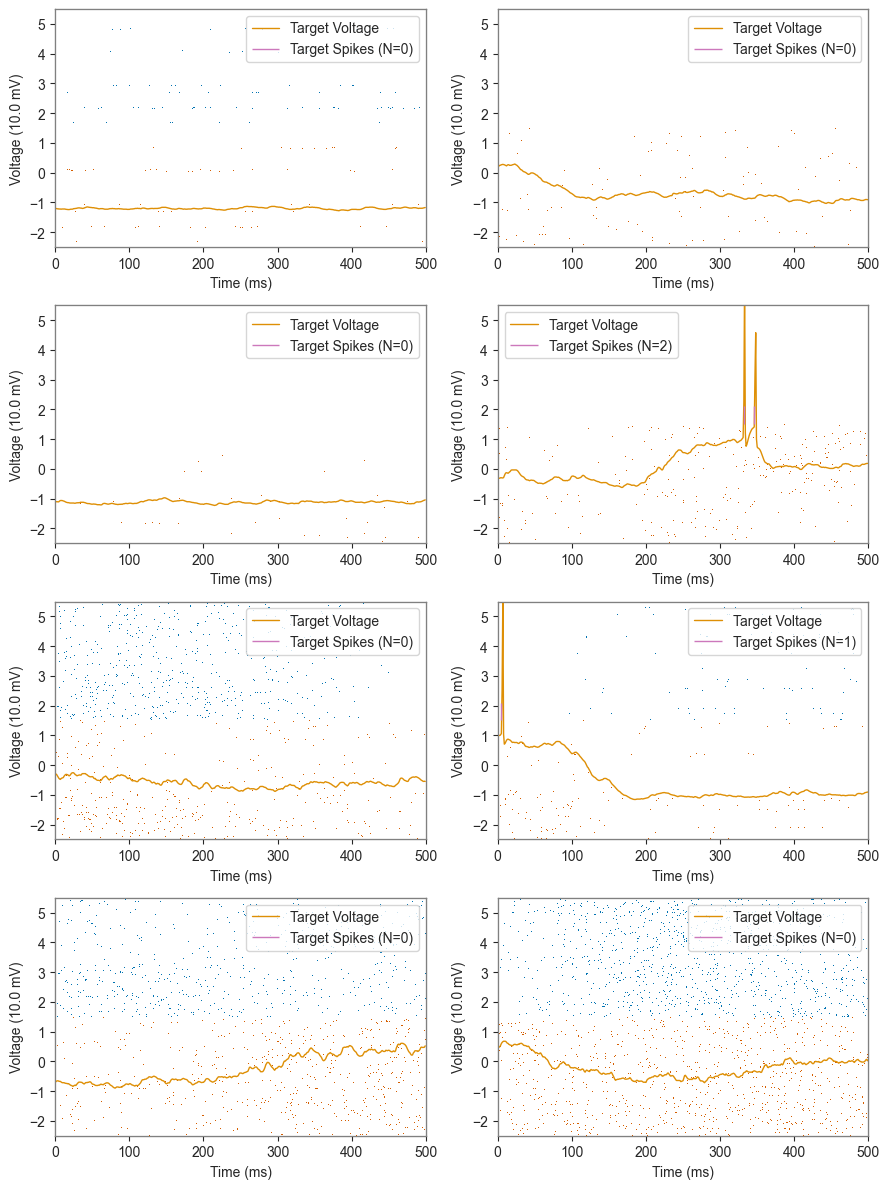

In [10]:
# Visualize training data
X_viz, (y_spike_viz, y_soma_viz) = next(iter(train_data_loader))
visualize_training_batch(X_viz, y_spike_viz, y_soma_viz, num_viz=8)

In [11]:
# Initialize the ELM model
elm_model = ELM(**model_config).to(torch_device)
#spiking_model = LIF(v_rest=-0.3, v_reset=0.0, v_threshold=1.27+0.1, spike_duration=1, tau=-1).to(torch_device)
model = self_inhibit(elm_model, v_threshold = 1.27, tau = 4.0, inh_strength=0.6, learn_scale=True, spike_func='relu', clamp=train_config["clamp"]).to(torch_device)

# if True:
#     torch.nn.init.normal_(model.w_y.weight, 0.05, 0.3/model_config["num_memory"])
#     torch.nn.init.constant_(model.w_y.bias, 0.0)

# Initialize the loss function, optimizer, and scheduler

MSEloss= nn.MSELoss(reduction="mean")
BCEloss = nn.BCELoss(reduction="mean")

optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=train_config["batches_per_epoch"] * train_config["num_epochs"]
)

In [12]:
# Visualize ELM model
print(model)

self_inhibit(
  (elm): ELM(
    (mlp): RecursiveScriptModule(
      original_name=MLP
      (network): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=ReLU)
        (2): RecursiveScriptModule(original_name=Linear)
      )
    )
    (w_y): RecursiveScriptModule(original_name=Linear)
  )
)


In [17]:
#X_sample = ((torch.rand([8, 500, 1278]) > 0.99) * 1.).to(torch_device)
#X_sample[:, 200:300, :] = ((torch.rand([8, 100, 1278]) > 0.4) * 1.).to(torch_device)
X_sample = X_viz
v, s, inh, v_clamp, out = model(X_sample)

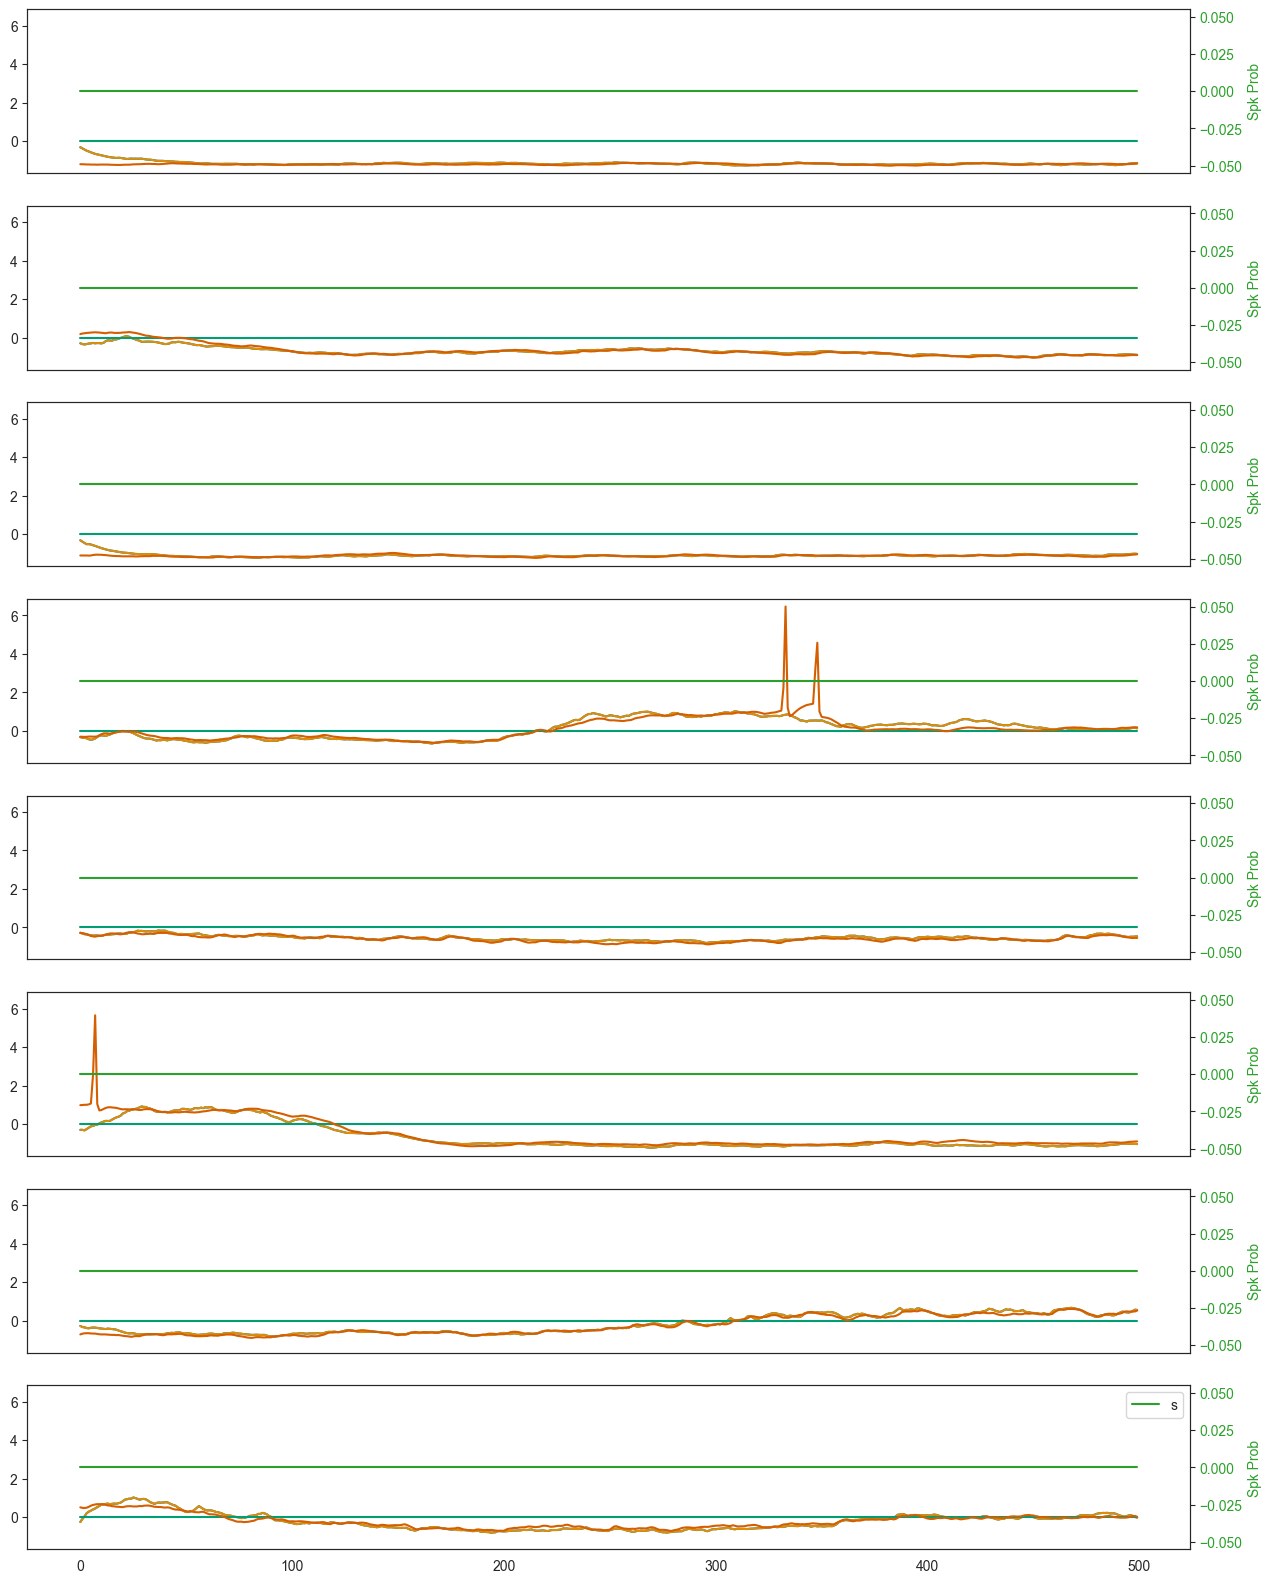

In [18]:
fig, axis = plt.subplots(train_config["batch_size"], 1, figsize=(15, 20), sharex=True, sharey=True)
for index in range(train_config["batch_size"]):
    axis[index].plot(out[index].detach().cpu().numpy(), label = "out")
    axis[index].plot(v[index].detach().cpu().numpy(), label = 'v')
    axis[index].plot(inh[index].detach().cpu().numpy(), label = 'inh')
    axis[index].plot(y_soma_viz[index].detach().cpu().numpy(), label = 'target_v')
    ax2 = axis[index].twinx()
    color = 'tab:green'
    ax2.set_ylabel('Spk Prob', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_ylim(-0.1, 1.0)
    ax2.plot(s[index].detach().cpu().numpy(), color=color, label = 's')
plt.legend()
plt.show()

In [16]:
# Initialize the best validation RMSE to a high value
best_valid_rmse = float('inf')
best_model_state_dict = model.state_dict().copy()

# Training loop
train_rmse_hist = []
train_auc_hist = []
valid_rmse_hist = []
valid_auc_hist = []
grad_norm=[]
for epoch in range(train_config["num_epochs"]):
    # Training
    model.train()
    running_loss = 0.0
    pbar = tqdm(
        enumerate(train_data_loader, 0),
        total=train_config["batches_per_epoch"],
        disable=not general_config["verbose"],
    )
    for i, data in pbar:
        inputs, targets = data
        
        # Perform a single training step
        optimizer.zero_grad()
        #outputs = model(inputs)
        v, s, inh, v_clamp, _ = model(inputs)
        loss = 0.5*BCEloss(s, targets[0]) + 0.5*MSEloss(v, targets[1])
        loss.backward()
        optimizer.step()
        scheduler.step()
        #grad_norm.append(model.w_y.bias.grad.detach().data)

        # Update running loss
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {running_loss / (i+1):.5f}")
    
    model.eval()
    with torch.no_grad():
        # Evaluate on training data
        train_eval_metrics = train_evaluator.evaluate(model)
        train_rmse = train_eval_metrics["soma_RMSE"]
        train_auc = train_eval_metrics["AUC"]
        train_rmse_hist.append(train_rmse)
        train_auc_hist.append(train_auc)

        # Evaluate on validation data
        valid_eval_metrics = valid_evaluator.evaluate(model)
        valid_rmse = valid_eval_metrics["soma_RMSE"]
        valid_auc = valid_eval_metrics["AUC"]
        valid_rmse_hist.append(valid_rmse)
        valid_auc_hist.append(valid_auc)

    # Copy model state dict if validation RMSE has improved
    if valid_rmse < best_valid_rmse:
        best_valid_rmse = valid_rmse
        best_model_state_dict = model.state_dict().copy()

    # Print statistics
    print(
        f'Epoch: {epoch+1}, '
        f'Train Loss: {running_loss / train_config["batches_per_epoch"]:.5f}, '
        f'Train RMSE: {train_rmse:.5f}, Train AUC: {train_auc:.5f}, '
        f'Valid RMSE: {valid_rmse:.5f}, Valid AUC: {valid_auc:.5f}'
    )

# Free up memory
del train_data_loader
gc.collect()

# Load the best model for evaluation
model.load_state_dict(best_model_state_dict)
model.eval();

Epoch 1 Loss: 0.10061: 100%|███████████████████████████████████████████████████████| 1000/1000 [09:54<00:00,  1.68it/s]


Epoch: 1, Train Loss: 0.10061, Train RMSE: 1.53947, Train AUC: 0.57797, Valid RMSE: 1.52677, Valid AUC: 0.56842


Epoch 2 Loss: 0.08654: 100%|███████████████████████████████████████████████████████| 1000/1000 [09:26<00:00,  1.77it/s]


Epoch: 2, Train Loss: 0.08654, Train RMSE: 1.43352, Train AUC: 0.59549, Valid RMSE: 1.43173, Valid AUC: 0.58574


Epoch 3 Loss: 0.08073: 100%|███████████████████████████████████████████████████████| 1000/1000 [09:33<00:00,  1.74it/s]


Epoch: 3, Train Loss: 0.08073, Train RMSE: 1.38649, Train AUC: 0.59420, Valid RMSE: 1.37659, Valid AUC: 0.58434


Epoch 4 Loss: 0.08808:  15%|████████▌                                               | 154/1000 [01:30<08:14,  1.71it/s]


KeyboardInterrupt: 

## LIF Training

In [16]:
X_sample = ((torch.rand([8, 500, 1278]) > 0.8) * 1.).to(torch_device)
#X_sample = X_viz
out = model(X_sample)
v, s, dv = spiking_model(out/1e1, y_soma_viz[:, 0])

TypeError: forward() takes 2 positional arguments but 3 were given

In [ ]:
fig = plt.figure(figsize=(12,4))
index = 1
plt.plot(out[index].detach().cpu().numpy(), label = "ode")
plt.plot(v[index].detach().cpu().numpy(), label = 'v')
plt.plot(s[index].detach().cpu().numpy(), label = 's')
plt.plot(y_soma_viz[index].detach().cpu().numpy(), label = 'target_v')
plt.legend()
plt.show()

In [ ]:
fig, axis = plt.subplots(train_config["batch_size"], 1, figsize=(15, 20), sharex=True, sharey=True)
for index in range(train_config["batch_size"]):
    axis[index].plot(out[index].detach().cpu().numpy(), label = "ode")
    axis[index].plot(v[index].detach().cpu().numpy(), label = 'v')
    axis[index].plot(s[index].detach().cpu().numpy(), label = 's')
    #axis[index].plot(y_soma_viz[index].detach().cpu().numpy(), label = 'target_v')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,4))
index = 1
plt.plot(out[index][150:400].detach().cpu().numpy(), label = "ode")
plt.plot(v[index][150:400].detach().cpu().numpy(), label = 'v')
plt.plot(s[index][150:400].detach().cpu().numpy(), label = 's')
plt.plot(y_soma_viz[index][150:400].detach().cpu().numpy(), label = 'target_v')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.plot(out[index][0:150].detach().cpu().numpy(), label = "ode")
plt.plot(v[index][0:150].detach().cpu().numpy(), label = 'v')
plt.plot(s[index][0:150].detach().cpu().numpy(), label = 's')
plt.plot(y_soma_viz[index][0:150].detach().cpu().numpy(), label = 'target_v')
plt.legend()
plt.show()

In [24]:
# Initialize the best validation RMSE to a high value
best_valid_rmse = float('inf')
best_model_state_dict = model.state_dict().copy()

# Training loop
train_rmse_hist = []
train_auc_hist = []
valid_rmse_hist = []
valid_auc_hist = []
grad_norm=[]
for epoch in range(train_config["num_epochs"]):
    # Training
    model.train()
    running_loss = 0.0
    pbar = tqdm(
        enumerate(train_data_loader, 0),
        total=train_config["batches_per_epoch"],
        disable=not general_config["verbose"],
    )
    for i, data in pbar:
        inputs, targets = data
        
        # Perform a single training step
        optimizer.zero_grad()
        outputs = model(inputs)
        v, s, dv = spiking_model(outputs/10., targets[1][:, 0])
        dv_target = targets[1][:, 1:]-targets[1][:, :-1]           #compute ode
        loss = 1e3*MSEloss(s, targets[0])# + 1e-2* MSEloss(v, targets[1])# + MSEloss(dv[:, :-1], dv_target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        grad_norm.append(model.w_y.bias.grad.detach().data)

        # Update running loss
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {running_loss / (i+1):.5f}")
    
    # model.eval()
    # with torch.no_grad():
    #     # Evaluate on training data
    #     train_eval_metrics = train_evaluator.evaluate(model)
    #     train_rmse = train_eval_metrics["soma_RMSE"]
    #     train_auc = train_eval_metrics["AUC"]
    #     train_rmse_hist.append(train_rmse)
    #     train_auc_hist.append(train_auc)

    #     # Evaluate on validation data
    #     valid_eval_metrics = valid_evaluator.evaluate(model)
    #     valid_rmse = valid_eval_metrics["soma_RMSE"]
    #     valid_auc = valid_eval_metrics["AUC"]
    #     valid_rmse_hist.append(valid_rmse)
    #     valid_auc_hist.append(valid_auc)

    # # Copy model state dict if validation RMSE has improved
    # if valid_rmse < best_valid_rmse:
    #     best_valid_rmse = valid_rmse
    #     best_model_state_dict = model.state_dict().copy()

    # # Print statistics
    # print(
    #     f'Epoch: {epoch+1}, '
    #     f'Train Loss: {running_loss / train_config["batches_per_epoch"]:.5f}, '
    #     f'Train RMSE: {train_rmse:.5f}, Train AUC: {train_auc:.5f}, '
    #     f'Valid RMSE: {valid_rmse:.5f}, Valid AUC: {valid_auc:.5f}'
    # )

# Free up memory
del train_data_loader
gc.collect()

# Load the best model for evaluation
model.load_state_dict(best_model_state_dict)
model.eval();

Epoch 2 Loss: 2.70625:   8%|████▌                                                    | 80/1000 [00:50<09:45,  1.57it/s]


KeyboardInterrupt: 

In [25]:
len(grad_norm)

1080

In [28]:
grad_norm = torch.stack(grad_norm)

In [29]:
grad = grad_norm.cpu().numpy()

(array([  1.,   1.,   0.,   1.,   1.,   1.,  11.,   6.,  22.,  56.,  62.,
        140., 206., 213., 160.,  69.,   1.,   1.,   5.,   5.,   6.,   4.,
          2.,   5.,   2.,   3.,   6.,   2.,   0.,   6.,   2.,   2.,   5.,
          3.,   6.,   6.,   1.,   2.,   4.,   3.,   3.,   2.,   2.,   3.,
          1.,   4.,   1.,   2.,   4.,   2.,   3.,   1.,   2.,   1.,   1.,
          0.,   0.,   0.,   2.,   1.,   1.,   1.,   1.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([-7.26544237, -6.801754  , -6.33806515, -5.87437677, -5.41068792,
        -4.94699955, -4.4833107 , -4.01962233, -3.55593371, -3.0922451 ,
        -2.62855673, -2.16486788, -1.7011795 , -1.23749065, -0.77380228,
        -0.31011343,  0.15357494,  0.61726332,  1.08095217,  1.54464102,
         2.00832891,  2.47

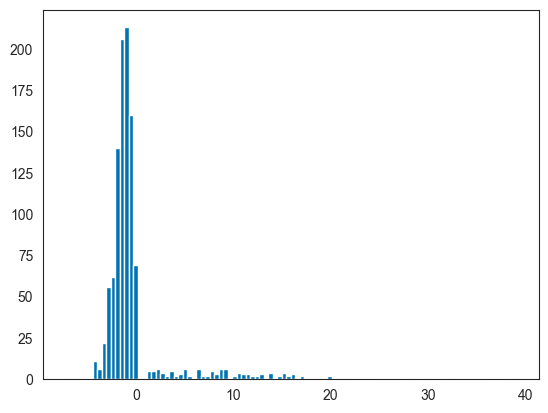

In [33]:
plt.hist(grad, bins=100)

## Evaluation

In [ ]:
# Visualize predictions
with torch.no_grad():
    outputs = model.neuronio_eval_forward(X_viz)
    visualize_training_batch(X_viz, y_spike_viz, y_soma_viz, outputs[..., 0], outputs[..., 1], num_viz=8)

In [16]:
# Gather all evaluation metrics
with torch.no_grad():
    if not general_config["short_training_run"]:
        random.seed(general_config["seed"])
        select_train_files = random.choices(train_files, k=10)
        train_predictions = compute_test_predictions_multiple_sim_files(
            neuron=model,
            test_files=select_train_files,
            burn_in_time=train_config["burn_in_time"],
            input_window_size=train_config["input_window_size"],
            device=torch_device,
        )
        train_results = filter_and_extract_core_results(*train_predictions, verbose=False)

        valid_predictions = compute_test_predictions_multiple_sim_files(
            neuron=model,
            test_files=valid_files,
            burn_in_time=train_config["burn_in_time"],
            input_window_size=train_config["input_window_size"],
            device=torch_device,
        )
        valid_results = filter_and_extract_core_results(*valid_predictions, verbose=False)

    test_predictions = compute_test_predictions_multiple_sim_files(
        neuron=model,
        test_files=test_files,
        burn_in_time=train_config["burn_in_time"],
        input_window_size=train_config["input_window_size"],
        device=torch_device,
    )
    test_results = filter_and_extract_core_results(*test_predictions, verbose=False)

eval_results = dict()
if not general_config["short_training_run"]:
    eval_results["train_results"] = train_results
    eval_results["valid_results"] = valid_results
eval_results["test_results"] = test_results

In [17]:
# Show evaluation results
eval_results

{'test_results': {'TP @ 0.0025 FP': 0.0865561694290976,
  'AUC @ 0.0025 FP': 0.04251381215469613,
  'TP @ 0.0100 FP': 0.26918354818907303,
  'AUC @ 0.0100 FP': 0.14777086218491403,
  'AUC': 0.9338153124011094,
  'soma_explained_variance_percent': 85.98870851908606,
  'soma_RMSE': 1.1480491917564262,
  'soma_MAE': 0.7998251122689763}}